<a href="https://colab.research.google.com/github/KamilShape/emotion_recognition/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**

In [1]:
#Libraries
import os
import cv2
from google.colab.patches import cv2_imshow
#----------------visualisation-------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data_path = 'drive/MyDrive/faces/data'

In [3]:
people = ['smiling-person', 'anger-person', 'disgust-person', 'fear-person', 'surprise-person' ]

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
photos_number = []
for person in people:
  photos_number.append(len(os.listdir(f'{data_path}/{person}')))

In [6]:
photos_number

[1200, 1169, 1190, 1173, 1198]

### 1.1 Data visualisation

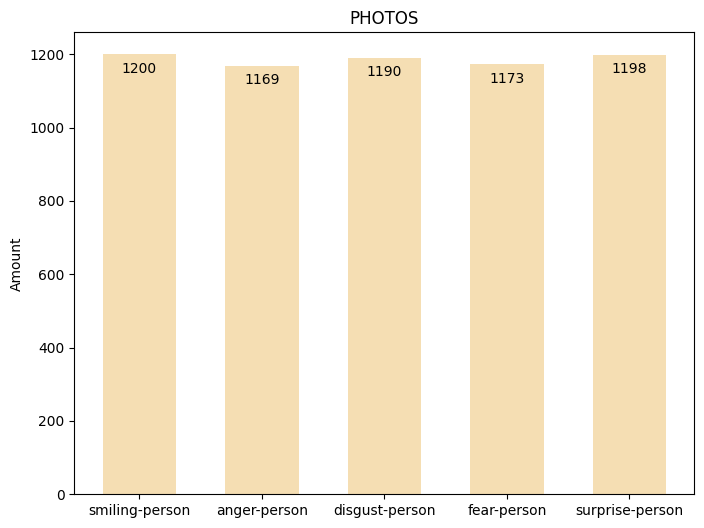

In [7]:
fig, ax = plt.subplots(figsize = (8,6))
ax.bar(people, photos_number, color='wheat', width=0.6)
ax.set_title('PHOTOS')
ax.set_ylabel('Amount')

for i in range(0, len(people)):
  ax.text(people[i], photos_number[i] - 50, horizontalalignment='center', s=photos_number[i] )

*Dataset is quite balanced.*

# **2. Face detection**

In [11]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
def face_recognition(photo, array):
  image = cv2.imread(photo)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  face = face_classifier.detectMultiScale(gray_image, 1.3, 4)
  if len(face) > 0:
   for i, (x, y, w, h) in enumerate(face):
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 255), 2)
      face = image[y:y + h, x:x + w]

      # array.append(face)
      # cv2_imshow(face)

In [14]:
smiling_faces = []
anger_faces = []
disgust_faces = []
fear_faces = []
surprise_faces = []
def faces_array(array, photos):
  print(f'{data_path}/{photos}')
  files_folder = os.listdir(f'{data_path}/{photos}')
  print(files_folder)
  for i in range(0, len(files_folder)):
    img_path = f'{data_path}/{photos}/{files_folder[i]}'
    print(img_path)
    image = cv2.imread(img_path)
    # cv2_imshow(image)
  # print(len(files_folder))
  # face_recognition
  # print(files_folder)

In [ ]:
faces_array(smiling_faces, "smiling-person")

In [ ]:
# anger_person_folder = os.listdir(f'{data_path}/anger-person')
# img_path = f'{data_path}/anger-person/{anger_person_folder[1]}'
# img = cv2.imread(img_path)
# print(img)
# img.shape
# cv2_imshow(img)